In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from PIL import Image
from torch.autograd import Variable
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import cv2

c:\Users\lucas\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\lucas\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# 1) Define model & layers
resnet_model = models.resnet50(pretrained=True)
vgg_model = models.vgg16(pretrained=True)
inception_model = models.inception_v3(pretrained=True)
inception_model.aux_logits = False
inception_model.eval()

resnet_layer = resnet_model._modules.get('avgpool')
vgg_layer = vgg_model._modules.get('avgpool')
inception_layer = inception_model._modules.get('avgpool')

c:\Users\lucas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lucas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\lucas/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 11.0MB/s]
c:\Users\lucas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 a

In [4]:
# 2) Define transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])

transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

transform_299 = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    normalize
])

In [5]:
# 3) Embedding extractor
def extract_hybrid_embeddings(image_path):
    resnet_emb = torch.zeros(2048)
    vgg_emb = torch.zeros(25088)
    inception_emb = torch.zeros(2048)

    img = Image.open(image_path).convert('RGB')

    input_224 = transform_224(img).unsqueeze(0)
    input_299 = transform_299(img).unsqueeze(0)

    def resnet_hook(module, inp, out):
        resnet_emb.copy_(out.data.view(-1))
    def vgg_hook(module, inp, out):
        vgg_emb.copy_(out.data.view(-1))
    def inception_hook(module, inp, out):
        inception_emb.copy_(out.data.view(-1))

    handle_rn = resnet_layer.register_forward_hook(resnet_hook)
    handle_vgg = vgg_layer.register_forward_hook(vgg_hook)
    handle_in = inception_layer.register_forward_hook(inception_hook)

    with torch.no_grad():
        _ = resnet_model(input_224)
        _ = vgg_model(input_224)
        _ = inception_model(input_299)

    handle_rn.remove()
    handle_vgg.remove()
    handle_in.remove()

    return torch.cat([resnet_emb, vgg_emb, inception_emb])

In [7]:
# 4) List images in folders
folderA = "./data/DAM_white_background"
folderB = "./data/preprocessed_test"

imagesA = [os.path.join(folderA, fn) for fn in os.listdir(folderA)
           if fn.lower().endswith(('.png', '.jpg', '.jpeg'))]
imagesB = [os.path.join(folderB, fn) for fn in os.listdir(folderB)
           if fn.lower().endswith(('.png', '.jpg', '.jpeg'))]

In [8]:
# 5) Compute embeddings
embeddingsA = []
for path in imagesA:
    embA = extract_hybrid_embeddings(path)
    embeddingsA.append(embA.unsqueeze(0))
embeddingsA = torch.cat(embeddingsA, dim=0)

embeddingsB = []
for path in imagesB:
    embB = extract_hybrid_embeddings(path)
    embeddingsB.append(embB.unsqueeze(0))
embeddingsB = torch.cat(embeddingsB, dim=0)

In [9]:
# 6) Match each B to best A
npA = embeddingsA.numpy()
npB = embeddingsB.numpy()

best_matches = []
for b_idx in range(len(imagesB)):
    b_emb = npB[b_idx].reshape(1, -1)        # shape: (1, 29184)
    sim_scores = cosine_similarity(b_emb, npA)[0]  # shape: (num_imagesA,)
    max_idx = np.argmax(sim_scores)
    max_score = sim_scores[max_idx]
    best_matches.append((b_idx, max_idx, max_score))

for b_idx, a_idx, score in best_matches[:5]:
    print(f"[B: {imagesB[b_idx]}] -> [A: {imagesA[a_idx]}], score={score:.4f}")

[B: ./data/preprocessed_test\image-20210928-102713-12d2869d.jpg] -> [A: ./data/DAM_white_background\M565SOAAUXM43R.jpeg], score=0.6365
[B: ./data/preprocessed_test\image-20210928-102718-2474636a.jpg] -> [A: ./data/DAM_white_background\M531SPCHFXM030.jpeg], score=0.6606
[B: ./data/preprocessed_test\image-20210928-102721-8eaea48f.jpg] -> [A: ./data/DAM_white_background\M531SPCHFXM030.jpeg], score=0.6542
[B: ./data/preprocessed_test\image-20210928-102725-7e28b44c.jpg] -> [A: ./data/DAM_white_background\M9203UYECM90B.jpeg], score=0.4661
[B: ./data/preprocessed_test\image-20210928-102729-f53d9faf.jpg] -> [A: ./data/DAM_white_background\M9203UYECM90B.jpeg], score=0.4915


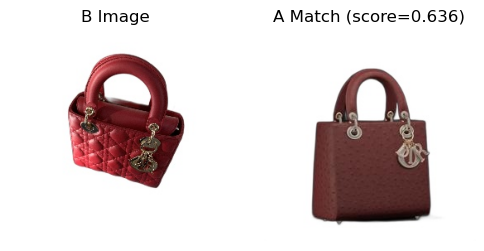

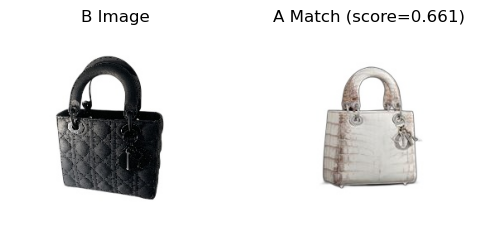

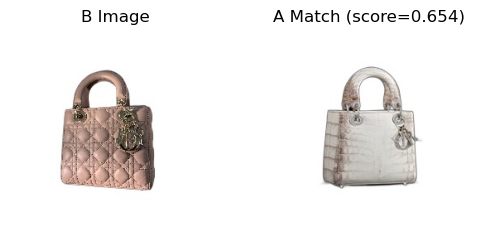

In [10]:
# 7) Optional visual check
def load_cv2_image(path):
    img_cv2 = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    return img_rgb

for b_idx, a_idx, score in best_matches[:3]:
    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].imshow(load_cv2_image(imagesB[b_idx]))
    axs[0].set_title("B Image")
    axs[0].axis("off")

    axs[1].imshow(load_cv2_image(imagesA[a_idx]))
    axs[1].set_title(f"A Match (score={score:.3f})")
    axs[1].axis("off")
    plt.show()

[B: ./data/preprocessed_test\image-20210928-102713-12d2869d.jpg] -> [A: ./data/DAM_white_background\M565SOAAUXM43R.jpeg], cosine_similarity=0.6365, MSE=0.7240, MAE=0.2242
[B: ./data/preprocessed_test\image-20210928-102718-2474636a.jpg] -> [A: ./data/DAM_white_background\M531SPCHFXM030.jpeg], cosine_similarity=0.6606, MSE=0.8016, MAE=0.2310
[B: ./data/preprocessed_test\image-20210928-102721-8eaea48f.jpg] -> [A: ./data/DAM_white_background\M531SPCHFXM030.jpeg], cosine_similarity=0.6542, MSE=0.6986, MAE=0.2141
[B: ./data/preprocessed_test\image-20210928-102725-7e28b44c.jpg] -> [A: ./data/DAM_white_background\M9203UYECM90B.jpeg], cosine_similarity=0.4661, MSE=0.6575, MAE=0.1989
[B: ./data/preprocessed_test\image-20210928-102729-f53d9faf.jpg] -> [A: ./data/DAM_white_background\M9203UYECM90B.jpeg], cosine_similarity=0.4915, MSE=0.6100, MAE=0.1887


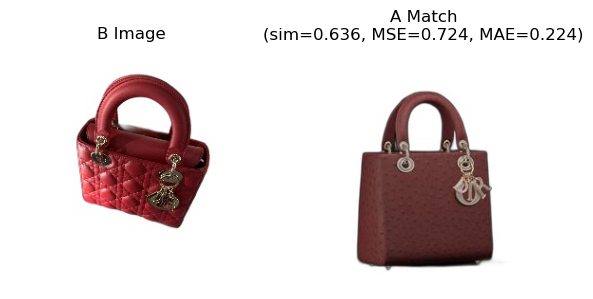

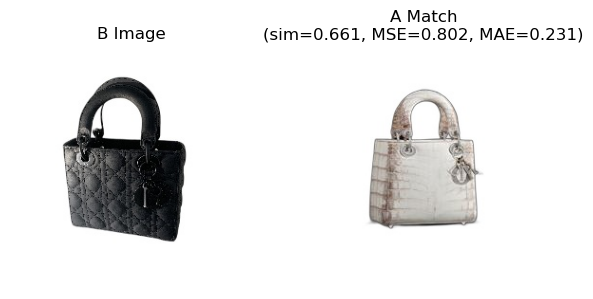

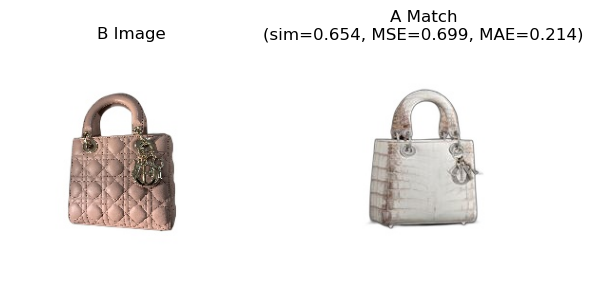

In [17]:
import numpy as np

def compute_mse(embedding1, embedding2):
    """
    Calculate Mean Squared Error (MSE) between two embeddings.

    Parameters:
    embedding1 (numpy.ndarray): First embedding vector.
    embedding2 (numpy.ndarray): Second embedding vector.

    Returns:
    float: MSE between the embeddings.
    """
    return np.mean((embedding1 - embedding2) ** 2)

def compute_mae(embedding1, embedding2):
    """
    Calculate Mean Absolute Error (MAE) between two embeddings.

    Parameters:
    embedding1 (numpy.ndarray): First embedding vector.
    embedding2 (numpy.ndarray): Second embedding vector.

    Returns:
    float: MAE between the embeddings.
    """
    return np.mean(np.abs(embedding1 - embedding2))

# Adapted Matching Process with MSE and MAE
best_matches_with_metrics = []
for b_idx in range(len(imagesB)):
    b_emb = npB[b_idx].reshape(1, -1)  # shape: (1, 29184)
    sim_scores = cosine_similarity(b_emb, npA)[0]  # shape: (num_imagesA,)

    max_idx = np.argmax(sim_scores)  # Best match index
    max_score = sim_scores[max_idx]  # Cosine similarity score
    
    # Calculate MSE and MAE for the best match
    mse = compute_mse(npB[b_idx], npA[max_idx])
    mae = compute_mae(npB[b_idx], npA[max_idx])

    # Append the results
    best_matches_with_metrics.append((b_idx, max_idx, max_score, mse, mae))

# Display the top 5 matches with metrics
for b_idx, a_idx, score, mse, mae in best_matches_with_metrics[:5]:
    print(f"[B: {imagesB[b_idx]}] -> [A: {imagesA[a_idx]}], "
          f"cosine_similarity={score:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Optional visual check with metrics
for b_idx, a_idx, score, mse, mae in best_matches_with_metrics[:3]:
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    
    axs[0].imshow(load_cv2_image(imagesB[b_idx]))
    axs[0].set_title("B Image")
    axs[0].axis("off")

    axs[1].imshow(load_cv2_image(imagesA[a_idx]))
    axs[1].set_title(f"A Match\n(sim={score:.3f}, MSE={mse:.3f}, MAE={mae:.3f})")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()
